Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [1]:
import thunder as td
import numpy as np

core_number = 6
machine_number = 2
# load some example image data
image_data = td.images.fromexample('fish', engine=sc)
image_data.repartition(core_number * machine_number)
# print the number of images
print("Number of images: %d"%image_data.count())

Number of images: 20


### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


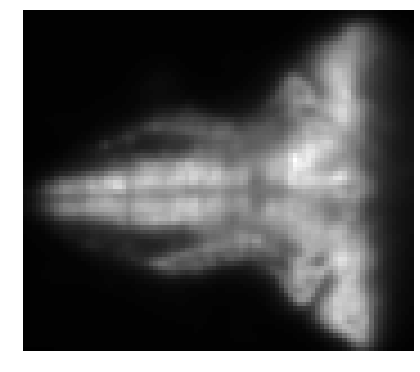

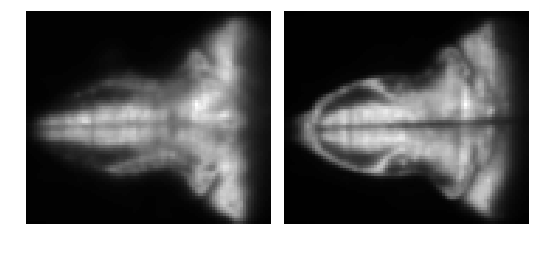

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0]);

# draw all layers of the first image
draw_tile(first_image);

# we can use index slices to take images
samples = image_data[0:6]



From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

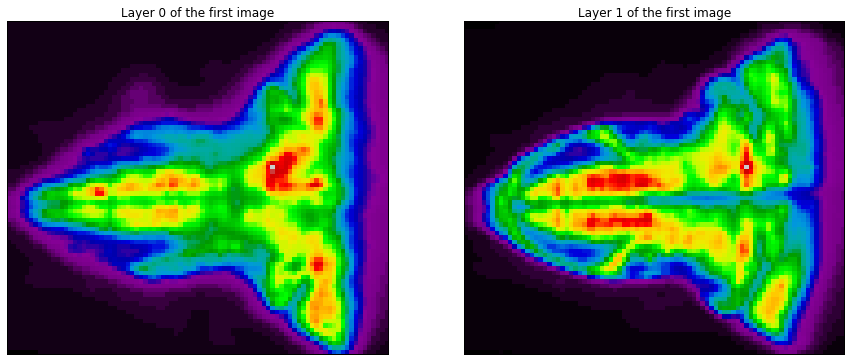

In [3]:
img = image_data.first() 
# or:
# img = image_data[1]

# function to display a defined number of images in the same row
def plot_layers_row(layers, img_per_row, title=None, **kwargs):
    if len(layers) == 0:
        return
    
    position = 100 + 10*img_per_row+1
    plt.figure(figsize=(15,9))
    for i,layer in enumerate(layers):
        plt.subplot(position)
        plt.imshow(layer, **kwargs)
        if title:
            plt.title(title[i])
        else:
            plt.title("Layer %d of the first image"%i)
        position+=1
        plt.xticks([])
        plt.yticks([])
    plt.show()

# show all the layers in the first image
layers = []
img_per_row = 2
for i,layer in enumerate(img):
    layers.append(layer)
    #plotting 2 images per row
    if (i+1) % img_per_row == 0:
        plot_layers_row(layers, img_per_row, interpolation='nearest', aspect='equal', cmap='nipy_spectral')
        layers = []

# in case the number of layers is odd
plot_layers_row(layers,img_per_row, interpolation='nearest', aspect='equal', cmap='nipy_spectral')

<div class="alert alert-success">

The parameters passed to <b>imshow</b> are the following:
<ul>
<li><i>interpolation</i>: defines how the image is rescaled, using <b>nearest</b> as interpolation method we are going to replace every pixel with multiple pixels of the same color, details are preserved but a "stairway" shape is visible on diagonal lines. Other methods provide smoother images but details can be lost,for this reason we decided to keep the nearest approach. Samples of different interpolation algorithms can be found <a href="http://matplotlib.org/2.0.0rc2/examples/images_contours_and_fields/interpolation_methods.html">here</a>
<br><br>
<li><i>aspect</i>: defines the aspect ratio of the image; by choosing <b>equal</b> we are changing the axes aspect ratio to match that of the image.
<br><br>
<li><i>cmap</i>: defines the colormap to be used to display the image.
</ul>
</div>

Then, we can perform operations that aggregate information across images.

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

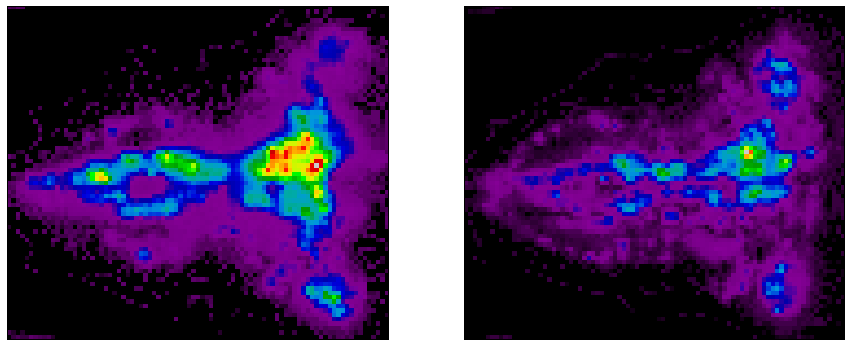

In [4]:
####!@SOLUTION@!####
# calculate standard deviation of images
std_imgs = image_data.std()
first_layer_std = std_imgs[:, 0]
second_layer_std = std_imgs[:, 1]
# x=draw_image(first)
# y=draw_image(second)
plot_layers_row([first_layer_std, second_layer_std], 2,title=["",""], 
                interpolation='nearest', aspect='equal', cmap='nipy_spectral')

<div class="alert alert-success">
We are computing the standard deviation of each voxel across different images to check how much a voxel varies over time.
<br><br>
<b><i>What does this mean?</i></b>
<br><br>
We are measuring the amount of different information on each pixel. We expect darker pixels where the brain activity is low and brighter pixels where the activity is high.
<br><br>
It is evident how the first layer shows more activity than the second, it is also important to notice that both the images are quite symmetric, that means that the areas of the brain that are active are symmetric even though one side seems to be more active. (Activities are on symmetric neurons but maybe do not share the same activities).
</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

Before subsampling: (20, 2, 76, 87)
After subsampling: (20, 2, 16, 18)


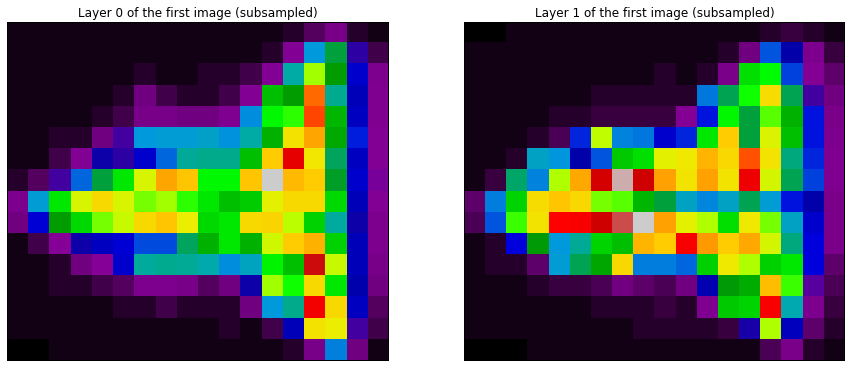

In [5]:
# keeping all the layers, reducing by a fifth both of the axis
subsampled = image_data.subsample((1, 5, 5))
first_img = subsampled.first()

# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension

print("Before subsampling:", image_data.shape)
print("After subsampling:", subsampled.shape)

plot_layers_row(first_img,2, title=["Layer 0 of the first image (subsampled)", 
                                   "Layer 1 of the first image (subsampled)"], 
                interpolation='nearest', aspect='equal', cmap='nipy_spectral')

As we can see the result of the subsampling is pretty evident, let's plot the subsampled image with the default function, for a better result we can change the interpolation method, the image will look blurry but less squared.

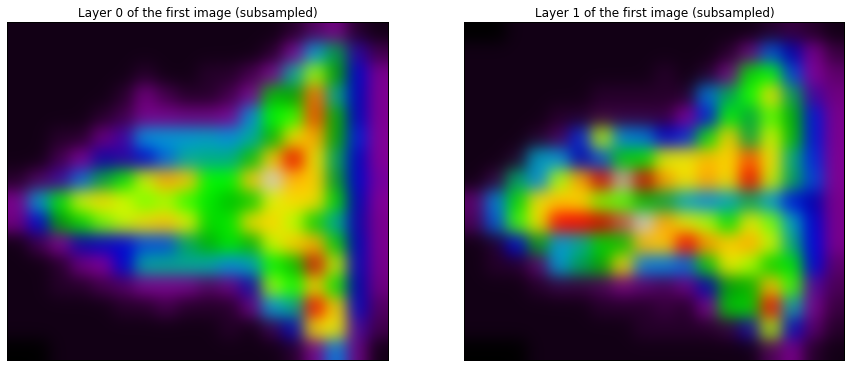

In [6]:
plot_layers_row(first_img,2, title=["Layer 0 of the first image (subsampled)", 
                                   "Layer 1 of the first image (subsampled)"], 
                interpolation='gaussian', aspect='equal', cmap='nipy_spectral')

<div class="alert alert-success">
Before subsampling the shape was:
\begin{equation}
(20, \ 2, \ 76, \ 87)
\end{equation}
and after the subsampling it became:
\begin{equation}
(20, \ 2, \ 16, \ 18)
\end{equation}
<br>
Basically, we have rescaled our image from a resolution of $(76,87)$ to a resolution of $(16,18)$ keeping both of the layers.
<br>If we wanted to remain with a single layer we should have modified the tuple given to <code>subsample()</code> in the following way: $(1, 5, 5) \rightarrow (2, 5, 5)$ since the first number would have stated that we want to reduce the number of layers by a factor of 2.
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [7]:
seriesRDD = image_data.toseries()
seriesRDD.cache()
print(seriesRDD)

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)


#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

<div class="alert alert-success">
The <b>Series</b> object is used to represent the evolution over time of a certain "entity". In our case the "entity" is a voxel and each number of the shape has a meaning:
<ul>
<li><b>2</b> is the number of layers;
<li><b>76</b> is the dimension of one of the axis;
<li><b>87</b> is the dimension of the second axis;
<li><b>20</b> is the number of states for each neuron.
</ul>
<br>
In other words, for each neuron we have a voxel, that translates into an ndarray, of length 20 that pictures the evolution of the neuron's state over time.
</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [8]:
# image_data.toseries().tobinary('directory', overwrite=True)
# ts = td.series.frombinary('directory', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [9]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [10]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0,0,0):", np.array(series_data[0,0,0,10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0,0,0): 25


<div class="alert alert-success">
We are showing the time series of the first voxel and we know that's a black one from what we've seen above.
<br><br>
We can see that the value doesn't vary much because it's not a "meaningful" area of the picture (top-left corner).
</div>

The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [11]:
print("shape of index:", series_data.index.shape)
print("the first element of a subset", series_data.between(0,8).first())

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [12]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())


[4, 5, 6, 7]
[26 26 26 25]


#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

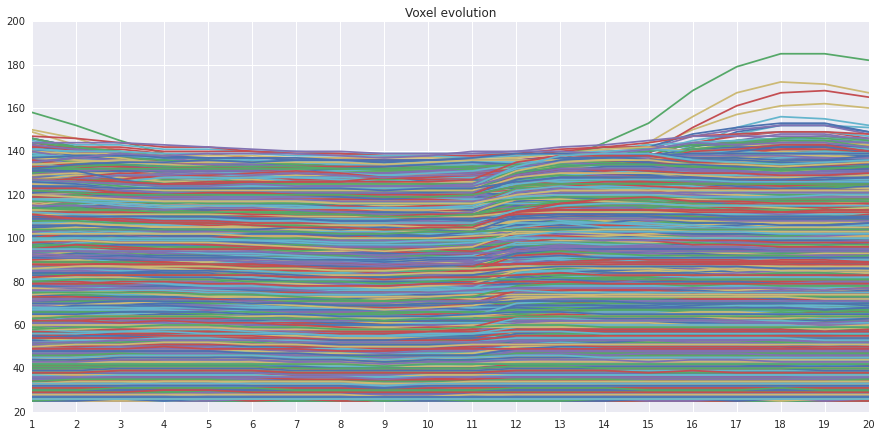

In [13]:
import numpy as np
import seaborn as sns
# only select the first 20 states of each object

#samples = series_data.between(0,20).tordd().values().collect()
samples = np.array(series_data.toarray())
s = np.reshape(samples, (2*76*87,20))

plot_size = (15,7)

#function used to show the voxel evolution
def plot_voxels(data, title = None, color_scheme = None):
    plt.figure(figsize=plot_size)
    plt.xticks(np.arange(1,21))
    if color_scheme:
        plt.gca().set_color_cycle(color_scheme.colors)
    if title:
        plt.title(title)
        
    if data.shape[0] == 20:
        plt.plot(np.arange(1,21),data)
    else:
        plt.plot(np.arange(1,21), data.T)
    plt.show()

plot_voxels(s, title="Voxel evolution")

<div class="alert alert-success">
It looks like most of the voxels share the same trend, keeping almost the same value until $t=11$ and getting an evident variation at $t=12$, at least this is what it seems from a messy picture like this one without preprocessing.
</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

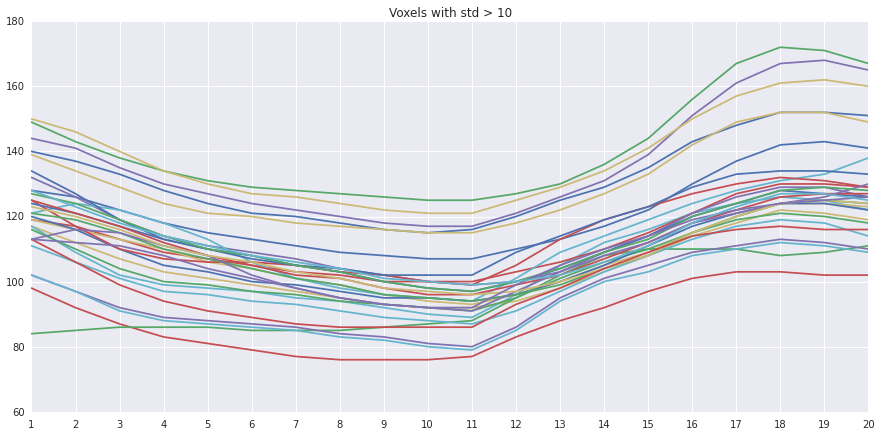

In [14]:
# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
threshold = 10
examples = series_data.filter(lambda x: x.std() > threshold).sample(30)
# only plot first 20 states of each object
plot_voxels(np.array(examples), title='Voxels with std > {:d}'.format(threshold))

<div class="alert alert-success">The figure above is way more clear than the previous one and shows 20 of the most varying voxels (according to the defined threshold).</div>

### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

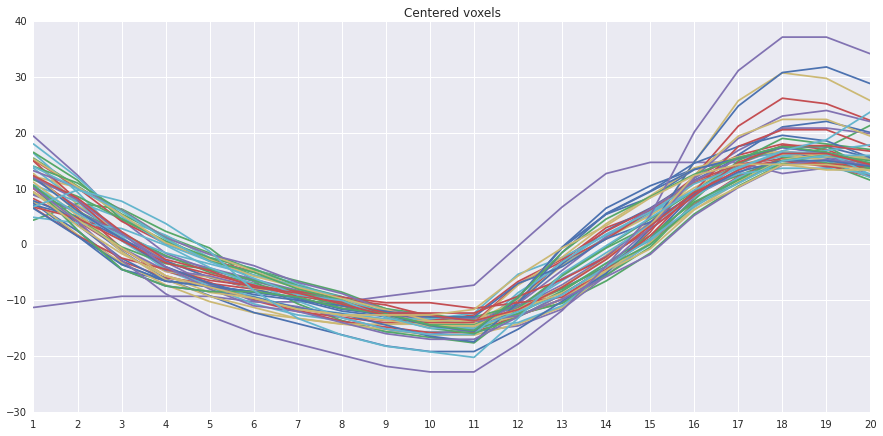

In [15]:
centered = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plot_voxels(np.array(centered), "Centered voxels")

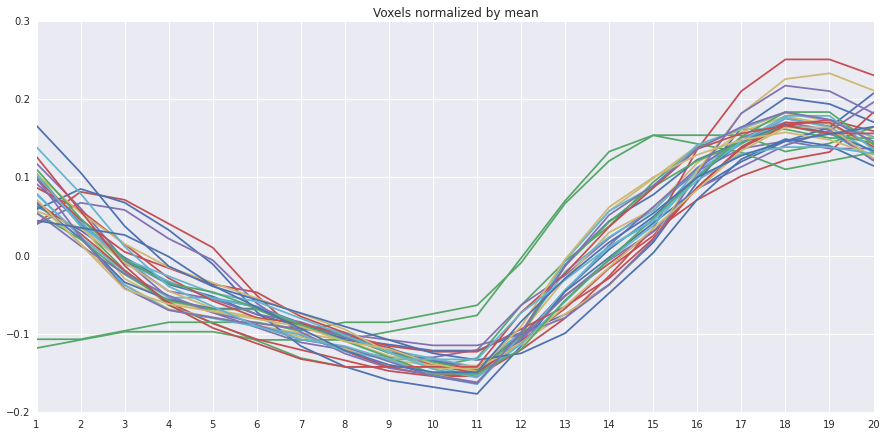

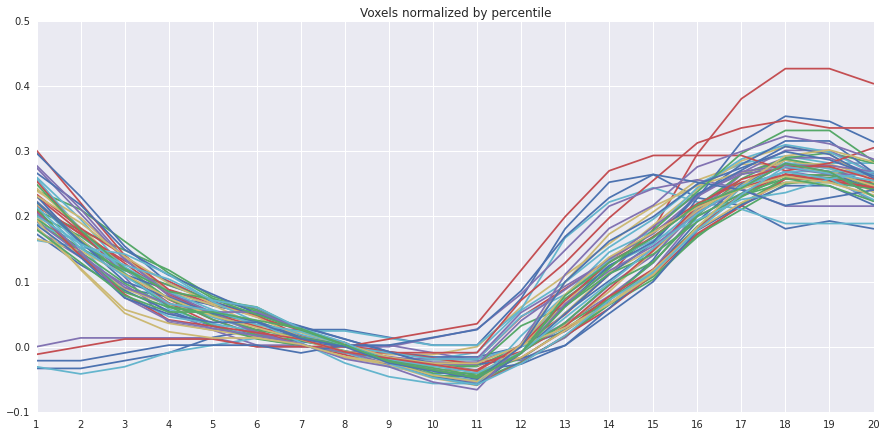

In [16]:
mean_normalized = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plot_voxels(np.array(mean_normalized), title='Voxels normalized by mean')
percentile_normalized = series_data.normalize().filter(lambda x: x.std() >= 0.1).sample(50)
plot_voxels(np.array(percentile_normalized), title='Voxels normalized by percentile')

<div class="alert alert-success">
After normalizing the data, we can see that the majority of the neurons decrease their own value until time $t=11$ and then start increasing again as if in that time they start a new activity.
</div>

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

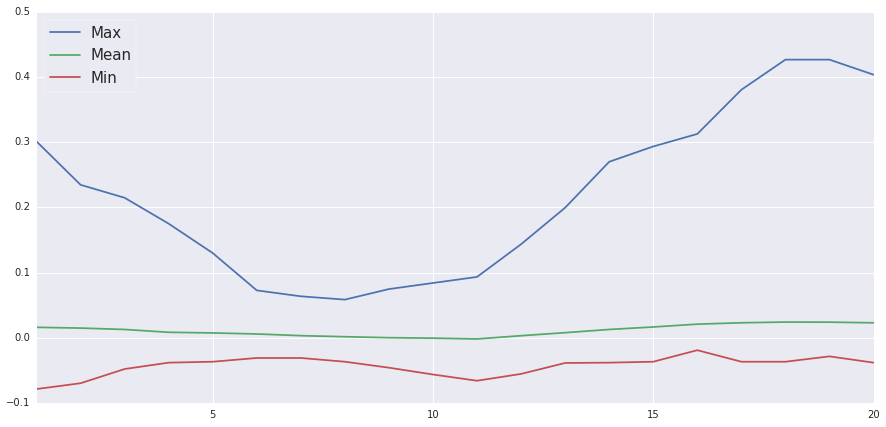

In [17]:
plt.figure(figsize=(15,7))
plt.xlim([1,20])
plt.plot(np.arange(1,21),series_data.normalize().max(), label="Max")
plt.plot(np.arange(1,21),series_data.normalize().mean(), label="Mean")
plt.plot(np.arange(1,21),series_data.normalize().min(), label="Min")
plt.legend(ncol=1, loc='upper left', frameon=True, fontsize=15)
plt.show()

<div class="alert alert-success">Note that <i>max</i>, <i>mean</i> and <i>min</i> are constructed by taking at each $t \in \left[0,20\right[$ the <i>max</i>, <i>mean</i> and <i>min</i> values across the series.</div>

To summarize **within records**, we can use the `map` method:

In [18]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

Series
mode: spark
dtype: float64
shape: (2, 76, 87, 1)


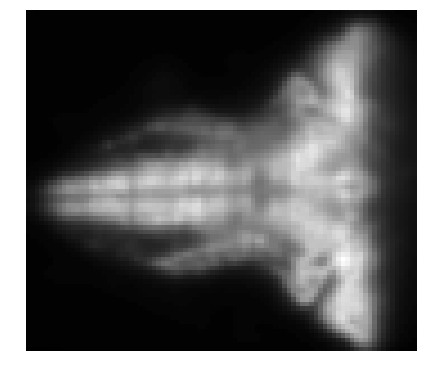

In [19]:
# we should recover the shape of means before plotting
print(means)
# draw the standard deviations of series that belong to the first layer
draw_image(flat_means.reshape((2, 76, 87)) [0,:,:]);

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [20]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())
first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itself:", corr)

The correlation of the first element with random signal: [-0.01349214]
The correlation of the first element with itself: [ 1.]


# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap

### b. Loading & inspecting the data

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [22]:
####!@SOLUTION@!####
# we must normalize it to get best clustering
#data = td.images.fromexample('fish').toseries().normalize()

# if no parameter is passed to normalize,the default method is percentile
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

data.repartition(core_number * machine_number)

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print (data.shape)

(2, 76, 87, 20)


<div class="alert alert-success">
As we expected from what we have seen before, the shape of the data tells us that we have 76x87 Series for each layer (2 in this case), that are 20 samples long.
</div>

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

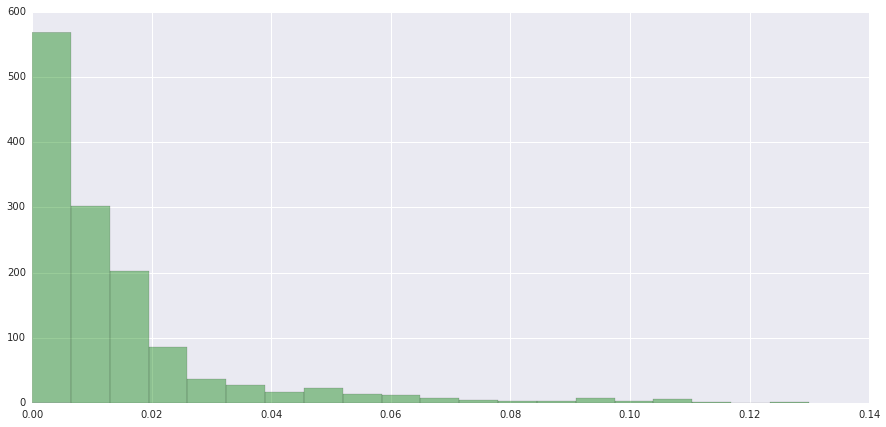

In [23]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
num_samples = int(data.count() *0.1)
stddevs = (data.map(lambda vox: vox.std()).flatten().sample(num_samples).toarray())

values, bins = np.histogram(stddevs, bins=20)
plt.figure(figsize=(15,7))
sns.distplot(stddevs, bins=20, color='g', kde=False);

In [24]:
# we are going to give a closer look at the distribution of the standard deviation among the selected voxels
import pandas as pd
from IPython.display import HTML

values_percentage = values/num_samples * 100
table = []
for i in range(len(bins)-1):
    std =  '{:f} ~ {:f}'.format(bins[i], bins[i+1])
    percentage = '{:.2f}%'.format(values_percentage[i])
    table.append([std, percentage])

df = pd.DataFrame(table)
df.columns = ["Standard deviation interval", "Voxel ratio"]

In [25]:
HTML(df.to_html())

,Standard deviation interval,Voxel ratio
0,0.000000 ~ 0.006495,43.04%
1,0.006495 ~ 0.012991,22.92%
2,0.012991 ~ 0.019486,15.36%
3,0.019486 ~ 0.025982,6.43%
4,0.025982 ~ 0.032477,2.72%
5,0.032477 ~ 0.038973,2.12%
6,0.038973 ~ 0.045468,1.21%
7,0.045468 ~ 0.051963,1.66%
8,0.051963 ~ 0.058459,0.98%
9,0.058459 ~ 0.064954,0.91%


<div class='alert alert-success'>
The histogram shows that the majority of voxels has a low variance that seems to vary in $\left[ 0, 0.007\right[
$ (depending on the sampling) .
<br><br>
In the table above we decided to show the percentage of voxels covered by each standard deviation interval.
<br>By choosing a threshold of <b>0.007</b> we are going to get rid of about <b>40 - 45%</b> of the voxels, considering the image, that seems a reasonable value.
<br><br>
Why did we say <i>considering the image</i>? Because, as seen in the drawing of the images above, a large amount of pixels is black and remains black, and so useless, for a long time. Below, we calculated the average number of black pixels in the images.
</div>

In [26]:
# counts the number of pixel that are considered black (below the threshold)
def count_black_pixels(image):
    count=0
    black_threshold = 30
    pixels=image.flatten()
    for pixel in pixels:
        if pixel < black_threshold:
            count+=1
    ratio = count/(len(pixels))
    return ratio


def black_pixels(something):
    black_pixels =  []
    for i in something:
        black_pixels.append(count_black_pixels(i))
    return black_pixels


images = td.images.fromexample('fish', engine=sc)
average_black_pixels = images.map(lambda image: black_pixels(image)).toarray().flatten().mean()

In [27]:
print("Average percentage of black pixels: %.2f %%"%(average_black_pixels*100))

Average percentage of black pixels: 40.66 %


<div class="alert alert-success">
The average amount of black pixels (or at least, of what we consider being a black pixel) is <b>40.66%</b>.
<br><br>
Therefore, our initial choice of the threshold value seems fair since it would cut off approx. <b>40%</b> of the data.
</div>

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

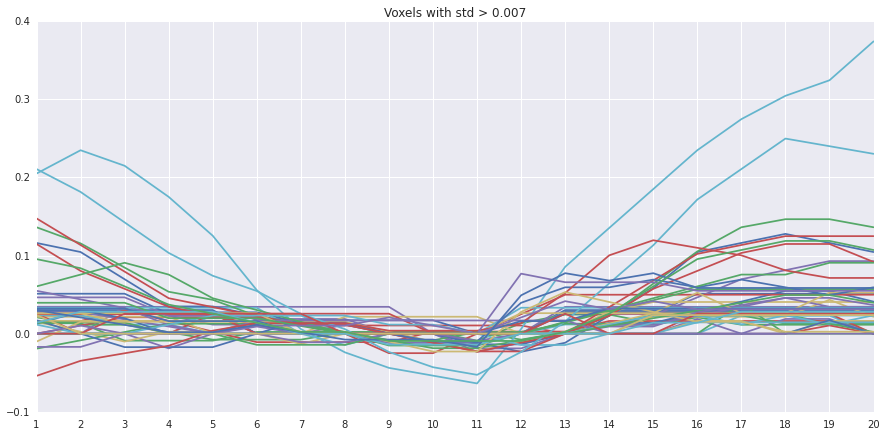

In [28]:
# sample 50 objects of the data randomly base on the standard deviation
threshold = 0.007
examples = data.filter(lambda x: x.std() > threshold).sample(50)
# plot the sample data
plot_voxels(np.array(examples).T, title='Voxels with std > {:.3f}'.format(threshold))

<div class="alert alert-success">Since we've filtered data according to the <i>standard deviation</i> we expect to see some variation in the data we plot, and that's exactly what happens in the chart above. To prove us right we're going to plot in the cell below 50 samples from the original data distribution (no std filtering). Since we are sampling from the whole dataset, there will be some voxel with a high std but in general the variation should be less evident than what we've shown above.</div>

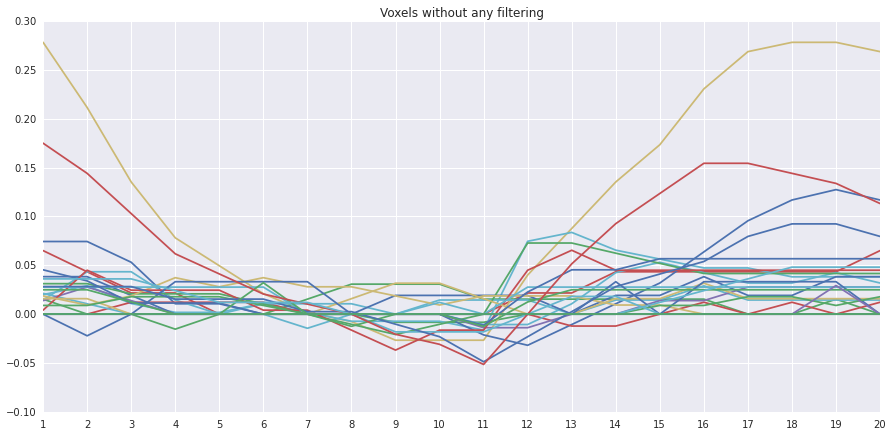

In [29]:
examples_2 = data.sample(50)
plot_voxels(np.array(examples_2).T, title="Voxels without any filtering")

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

In [30]:
# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()

In [31]:
import time
# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]

#version working with mllib
def buildModels(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    total = 0
    for k in ks:
        t0 = time.time()
        print("KMeans k = %4d ..." %k, end=' ')
        models.append(KMeans.train(data,k)) 
        t1 = time.time()
        print("[DONE] took %4.2f seconds" %(t1-t0))
        total += t1-t0
    print("Total build time: %4.2f"%total)
    return models

models = buildModels(training_data)

KMeans k =    5 ... [DONE] took 3.92 seconds
KMeans k =   10 ... [DONE] took 2.52 seconds
KMeans k =   15 ... [DONE] took 4.40 seconds
KMeans k =   20 ... [DONE] took 2.78 seconds
KMeans k =   30 ... [DONE] took 3.74 seconds
KMeans k =   50 ... [DONE] took 4.06 seconds
KMeans k =  100 ... [DONE] took 7.52 seconds
KMeans k =  200 ... [DONE] took 4.59 seconds
Total build time: 33.54


<div class="alert alert-success">
The code above doesn't involve parallelization of the KMeans model. The <code>for</code> loop uses the KMeans function once for every value in the <code>ks</code> vector.
<br><br>
We tried a different approach:
<br>
<ul>
<li>We parallelized the vector <code>ks</code>. In this way, the elements of the vector are copied to form a distributed dataset that can be operated on in parallel.
<li>We broadcasted the <code>data</code> such that it would be sent to every cluster. Since the variable is read-only, we could use this feature to read it on distributed functions much faster.
<li>We used KMeans function of the <code>sklearn.cluster</code> library.
</ul>
<br>
The main difference between the two is that the first runs one KMeans at a time instead the parallel version runs the different KMeans models at the same time.
</div>

In [32]:
#PARALLEL VERSION
from sklearn.cluster import KMeans as KMeansSKLearn

ksParallel = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200])

training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def buildModelsParallel(data):
    bData = sc.broadcast(data.collect())    
    models = ksParallel.map(lambda k: KMeansSKLearn(k).fit(bData.value))
    return models.collect()

t0 = time.time()
modelsParallel = buildModelsParallel(training_data)
print("Total build time:", time.time() - t0, "seconds")

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


Total build time: 16.14972448348999 seconds


<div class="alert alert-success">The parallel version of the KMeans algorithm managed to reduce the building time by almost half with respect to the non parallel version.</div>

<div class="alert alert-success">
<div class="label label-warning">NOTE:</div> The implementation of the parallel version of KMeans has been done at the end of the notebook since the dataset is small and a speed up for the computation was not needed.
</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

#### Question 11
<div class="alert alert-info">a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?
</div>

In [33]:
from scipy.spatial.distance import cdist, sqeuclidean

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    return data.map(lambda series: sqeuclidean(series, model.clusterCenters[model.predict(series)])).sum()

<div class="alert alert-success">
We’d expect this metric to be <b>monotonic decreasing</b> with k.
<br><br>
This is obvious if we consider how K-Means works internally; at each iteration the algorithm assigns each point to the closest centroid/medoid, so if we increase the number of clusters, each point will have a centroid that is closer with respect to the previous case. K-Means clustering naturally optimizes object distances, and a distance-based internal criterion will likely overrate the resulting clustering. 
<br>
Because of this, taking into account only this measure, will make us a reach a point where $k$ equals the number of points and so, every point would be assigned to its own cluster with a total distance of 0.
<br><br>
Having said that, we can still get an idea of a good value for $k$ by looking for a significant decrease of the error.
</div>

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [34]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    # np.corrcoef computes the Pearson correlation coefficient, 
    #in this case between the point and the closest centroid
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    centers = model.clusterCenters
    return 1. / data.map(lambda series: similarity(centers, series)).sum()

<div class="alert alert-success">The main problem of the metric used above is that a similarity of 0 is returned everytime a voxel series has a standard deviation equal to 0.
<br>
By doing this we are penalizing the scenario in which all of the voxel series that don't vary go into the same cluster because, by giving a similarity of 0, we are increasing the error even if the  is perfectly correct (in the sense that if we group in the same cluster pixels with std=0, it would be correct).
</div>

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

In [35]:
from sklearn.metrics import silhouette_score

def testAndPlotTheResult(data, models, silhouette=False):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data, model) for model in models])
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data, model) for model in models])
    # plot the errors with each value of K
    plt.figure(figsize=(15,7))
    plt.xlim([0,205])
    plt.xticks(ks)
    plt.plot(ks, errors_1 / errors_1.sum(), 'k-o', label='Squared Euclidean Distance')
    plt.plot(ks, errors_2 / errors_2.sum(), 'b:v', label='Similarity')
    if silhouette:
        train_array = np.array(data.collect())
        silhouettes = []
        for model in models:
            train_labels = np.array(data.map(lambda vox: model.predict(vox)).collect())
            silhouettes.append(1/(silhouette_score(train_array, train_labels)+1))
            
        plt.plot(ks, silhouettes/sum(silhouettes),'-.D', label='Silhouette', color='r')

    plt.legend()
    plt.show()

<div class="alert alert-success">
<div class="label label-warning">NOTE:</div>
In the cell above we used the <i>silhouette_score</i> metric implemented in <b>sklearn</b> because the amount of data doesn't require a parallel and faster execution on a cluster. For a bigger dataset we would have used the silhouette function implemented in the previous lab which takes into account centroids instead of the full dataset.
</div>

/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


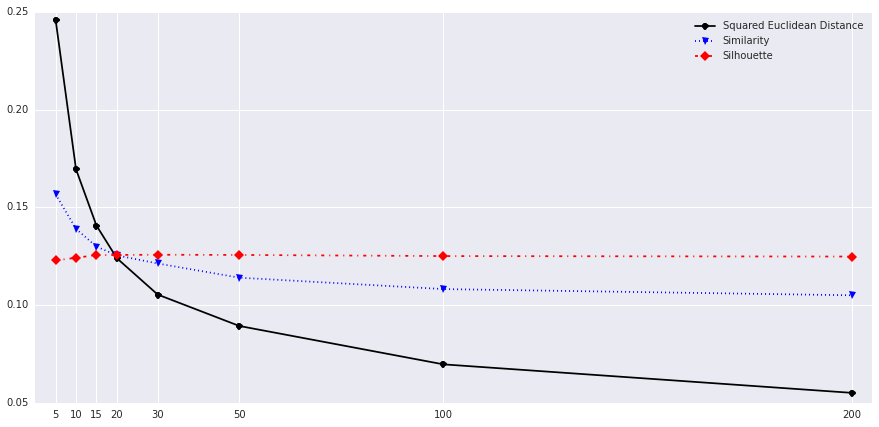

In [36]:
testAndPlotTheResult(training_data, models, silhouette=True)

<div class="alert alert-success">We have modified the given function <code>testAndPlotTheResult</code> in order to show another metric, the <i>silhouette</i>, which is defined in $ \left [-1, +1 \right] $. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. To plot it alongside the other errors we've modified it so that it's defined in $ \left [0, 2 \right] $ and defined an error as the inverse of the silhouette itself.
<br><br>
To select a good value for $k$ we're looking for a significant decrease of the errors associated with a reasonably small number of clusters. What's clear from the figure above is that the 3 metrics share the same error for $k=20$ and a greater value doesn't imply big improvements, so $k=20$ seems a good candidate.
<br><br>
It's interesting to notice how in this case the silhouette does not decrease with the number of clusters (differently from the other metrics) but it's pretty much stable. This means that the data is evenly distributed in the space and increasing the number of clusters doesn't split the data further nor divides the cluster in a much more distinct way (possibly the effective number of clusters doesn't increase that much).
</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

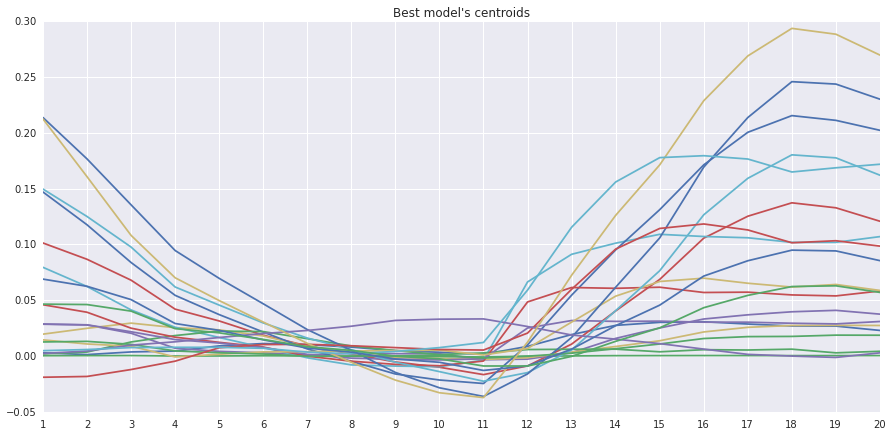

In [37]:
# plot the centroids of the best performing model
best_k = 20
bestModel = models[ks.index(best_k)]
plot_voxels(np.array(bestModel.clusterCenters).T, title="Best model's centroids")

<div class="alert alert-success">The cluster centers are sufficiently separated but some of them look alike. That's probably due to the fact that we didn't clean our data at all, so we expect better results in the further questions where we are going to apply some filtering.</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

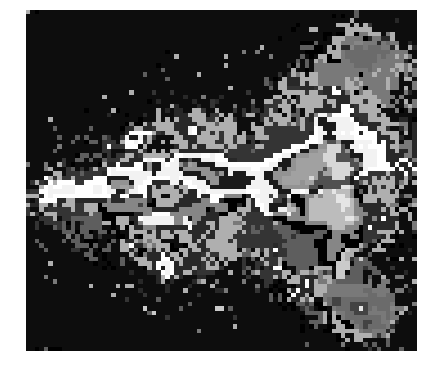

In [38]:
# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModel.predict(x))
# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

# consider the voxel of the first layers
draw_image(imgLabels[0, :, :]);

<div class="alert alert-success">Even if the colors don't give us any information about the similarity between clusters, it is clear that our model has some issues because some of the points that are supposed to be black are clustered with active neurons (note the white points outside the brain).</div>

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smarter color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

In [39]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)
# generate the better color scheme
newClrs = optimize_color(bestModel.centers)

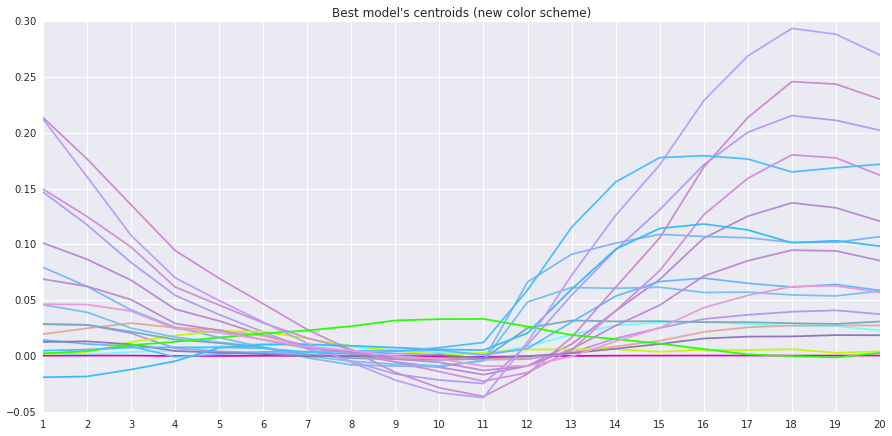

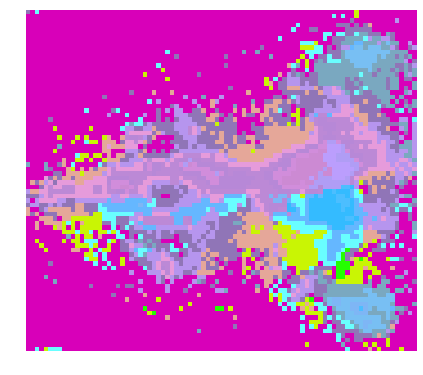

In [40]:
plot_voxels(np.array(bestModel.centers).T,title="Best model's centroids (new color scheme)", color_scheme=newClrs)

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap);

### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

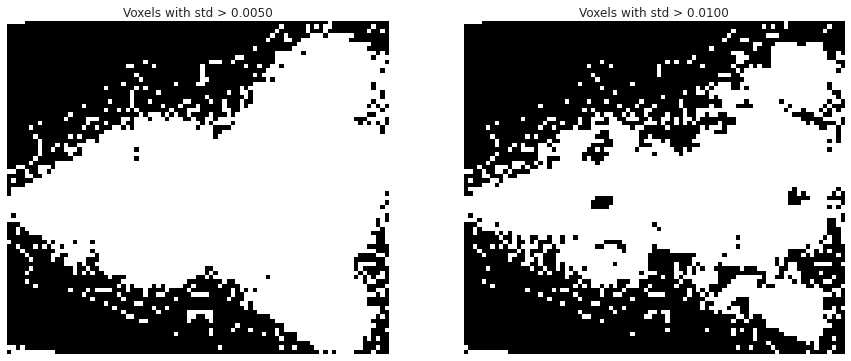

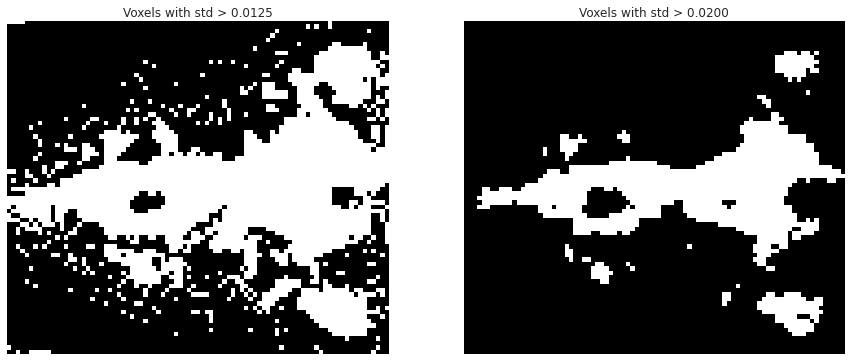

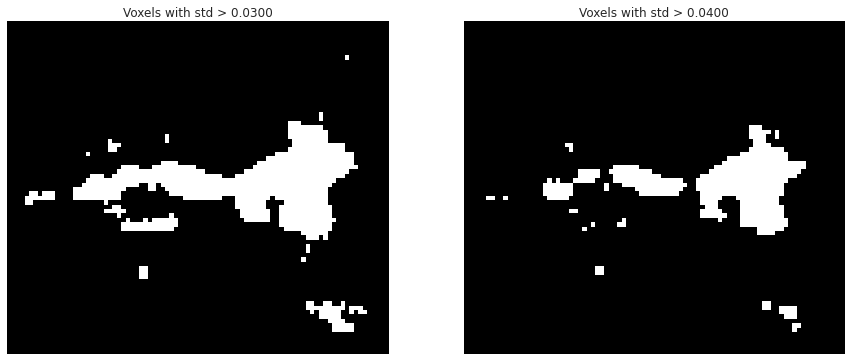

In [41]:
# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda vox : vox.std()).toarray().reshape(2, 76, 87)

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
thresholds = [0.005, 0.01, 0.0125, 0.02, 0.03, 0.04]
for i,t in enumerate(thresholds):
    if i % 2 == 0:
        imgs = []
        imgs.append(stdMap[0,:,:] > t)
    else:
        imgs.append(stdMap[0,:,:] > t)
        plot_layers_row(imgs, 2, title=["Voxels with std > {:.4f}".format(thresholds[i-1]),
                                        "Voxels with std > {:.4f}".format(thresholds[i])],
                        interpolation='nearest', aspect='equal', cmap='gray')


<div class="alert alert-success">
We looked for more information about zebrafish brain and found the following picture, in which active neurons (magenta) were marked while the fish was swimming freely. According to the picture we believe that a threshold of <b>0.0125</b> is a good value. More information about the image can be found <a href="http://www.hhmi.org/news/new-fluorescent-protein-permanently-marks-neurons-fire">here</a>.
<br><br><div class="label label-warning"><b>NOTE:</b></div> The images that we have refere only to the part of the brain circled in the picture, not the whole brain.<br>
<img src="https://image.ibb.co/k1aBd5/Ca_MPARI_zebrafish_brain_confocal_horizontal.jpg" alt="Ca_MPARI_zebrafish_brain_confocal_horizontal" border="0">
</div>

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [42]:
####!@SOLUTION@!####
from numpy import std
threshold = 0.0125
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() > threshold).cache()
print(filtered.shape)

(4692, 20)


<div class="alert alert-success">
As we can see from the shape of the filtered dataset, we remained with 4692 from the starting 13224, that means we filtered around <b>65%</b> of the initial data.
</div>

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

KMeans k =    5 ... [DONE] took 2.42 seconds
KMeans k =   10 ... [DONE] took 1.49 seconds
KMeans k =   15 ... [DONE] took 2.20 seconds
KMeans k =   20 ... [DONE] took 4.13 seconds
KMeans k =   30 ... [DONE] took 3.19 seconds
KMeans k =   50 ... [DONE] took 2.33 seconds
KMeans k =  100 ... [DONE] took 2.21 seconds
KMeans k =  200 ... [DONE] took 2.47 seconds
Total build time: 20.44


/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


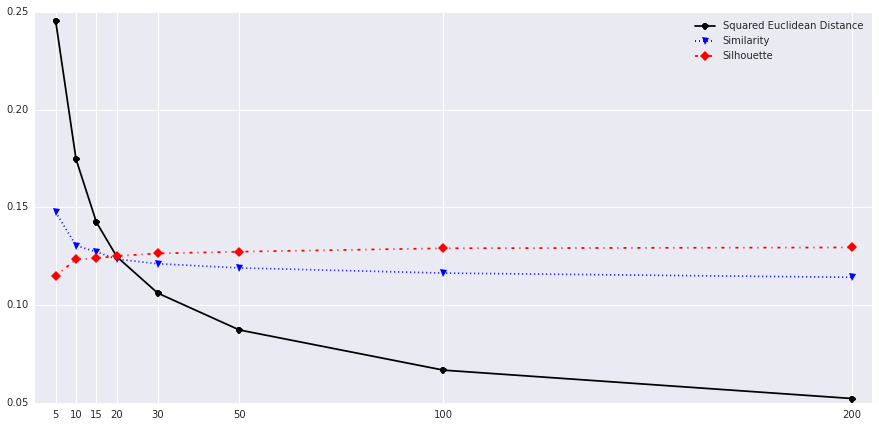

In [43]:
filtered_training_data = filtered.tordd().map(lambda x: np.array(x[1])).cache()
filtered_models = buildModels(filtered_training_data)
testAndPlotTheResult(filtered_training_data, filtered_models, silhouette=True)

<div class="alert alert-success">
The new graph looks pretty much like the old one, except for the fact that the error based on <i>Similarity</i> seems to converge faster and to an higher value. Again $k=20$ seems to be a good choice.
</div>

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

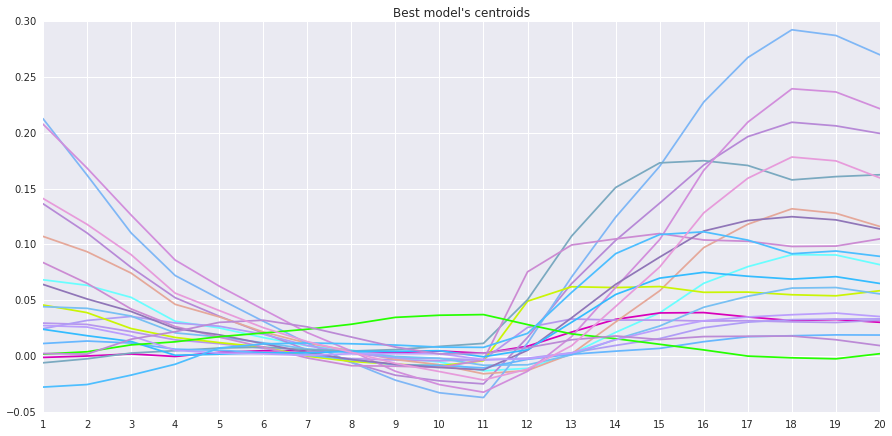

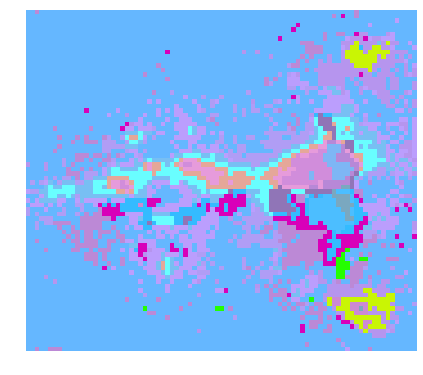

In [44]:
best_filtered_k = 20
best_filtered_model = filtered_models[ks.index(best_filtered_k)]

plot_voxels(np.array(best_filtered_model.clusterCenters).T, color_scheme=newClrs, \
            title="Best model's centroids")

labels = data.map(lambda x: best_filtered_model.predict(x))
# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

# plot image with new colors
colored_brain = transform(newClrs, imgLabels[0, :, :])
draw_image(colored_brain);

<div class="alert alert-success">
The results aren't so much different.
<br><br>
The main difference between this new color map and the previous, is that all the black pixels are grouped with the cluster of the points that change less (above the threshold we chose before). In this way, we are choosing one threshold, but all the points in the <i>worst</i> cluster will be grouped together with the points that were filtered out and so it will be like actually passively increasing the threshold when plotting.
</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

(2, 76, 87)


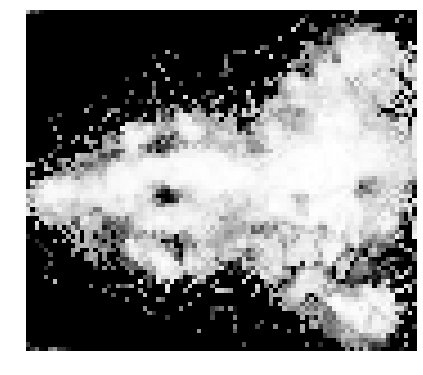

In [45]:
sim = data.map(lambda x: similarity(best_filtered_model.centers, x))
imgSim = sim.toarray()
print(imgSim.shape)
# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1));

And, it can be used as a linear mask on the colorization output

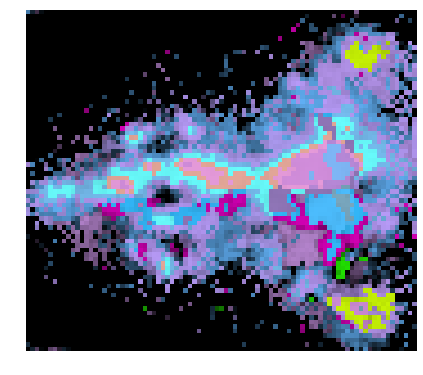

In [46]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap);

<div class="alert alert-success">
A black mask has been applied to the pixels that do not fit well in the cluster they belong to based on the similarity metric. Since we're considering the model built keeping out the steady voxels, there will be clusters containing both steady and varying voxels, that's when the similarity measure becomes useful.
</div>

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

<div class="alert alert-success">
<div class="label label-warning">NOTE:</div> We need to define a way to split the data in training and test set (they need to be of the same size otherwise the model cannot be tested, since the centroid and the data to predict must be of the same dimensionality for the prediction to work).
<br><br>
At first we tried with a random split, obtained by generating 10 random indexes to select in the time series.
<br>
Then, we realized that it wasn't a good idea because 10 random samples are not enough to represent properly the evolution of the pixel, so we chose to split on even and odd indexes in order to better catch the evolution over time.
</div>

In [47]:
# array of indexes from 0 to 20
idx = np.arange(20)
# shuffling the indexes, the first part will be used for training, the remaining for testing
#np.random.shuffle(idx)
training_ratio = int(0.5*20)
# train_idx = idx[:training_ratio]
# test_idx = idx[training_ratio:]
train_idx = [i for i in idx if i%2==0]
test_idx = [i for i in idx if i%2!=0]
training_data = data.select(lambda x: x in train_idx)
test_data = data.select(lambda x : x in test_idx)

training_set = training_data.filter(lambda x: x.std() > threshold).tordd()\
                .map(lambda x: np.array(x[1])).cache()
test_set = test_data.filter(lambda x: x.std() > threshold).tordd()\
                .map(lambda x: np.array(x[1])).cache()

KMeans k =    5 ... [DONE] took 1.83 seconds
KMeans k =   10 ... [DONE] took 3.34 seconds
KMeans k =   15 ... [DONE] took 1.32 seconds
KMeans k =   20 ... [DONE] took 1.46 seconds
KMeans k =   30 ... [DONE] took 2.29 seconds
KMeans k =   50 ... [DONE] took 2.01 seconds
KMeans k =  100 ... [DONE] took 2.20 seconds
KMeans k =  200 ... [DONE] took 3.98 seconds
Total build time: 18.42


/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


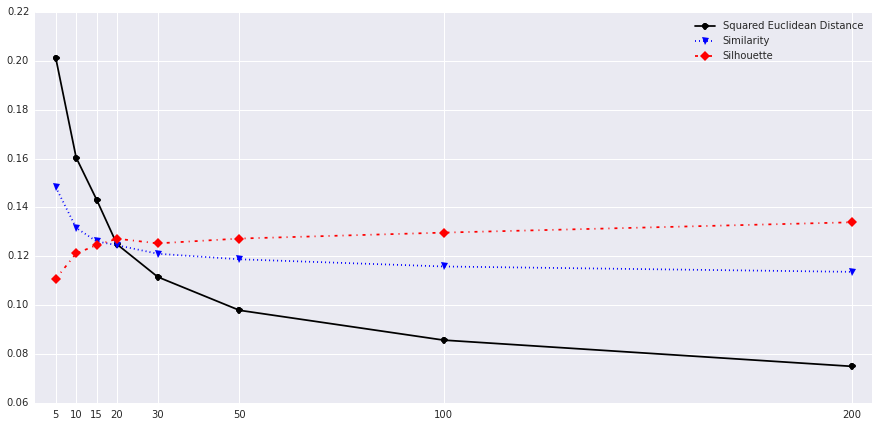

In [48]:
models = buildModels(training_set)
testAndPlotTheResult(test_set, models, silhouette=True)

<div class="alert alert-success">
Let us keep $k=20$ and plot the cluster labels with the selected model.
</div>

In [49]:
best_k = 20
best_model = models[ks.index(best_k)]
training_labels = training_data.map(lambda x: best_model.predict(x))
test_labels  = test_data.map(lambda x: best_model.predict(x))

img_training_labels = training_labels.toarray().reshape(2, 76, 87)
img_test_labels = test_labels.toarray().reshape(2, 76, 87)

In [50]:
# plot image with new colors
imgs = []
training_sim = training_data.map(lambda x: similarity(best_model.centers, x))
test_sim = test_data.map(lambda x: similarity(best_model.centers, x))

colored_brain_train = transform(newClrs, img_training_labels[0, :, :], mask=training_sim[0,:,:])
colored_brain_test = transform(newClrs, img_test_labels[0, :, :], mask=test_sim[0,:,:])
imgs.append(colored_brain_train)
imgs.append(colored_brain_test)

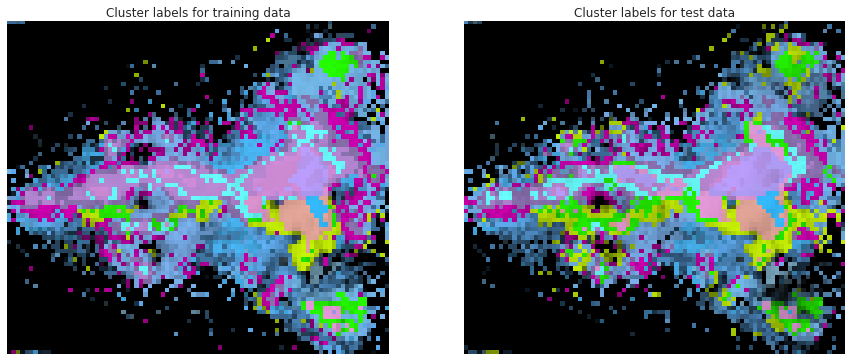

In [51]:
plot_layers_row(imgs, 2, title=["Cluster labels for training data","Cluster labels for test data"],
                interpolation='nearest')

<div class="alert alert-success">The images above show respectively the clusters' label obtained on the training set (left) and on the test set (right). The result is pretty good because the 2 pictures look very similar, especially the different cluster shades from the outside to the inside. Of course some information is lost as you may notice from the cyan cluster on the middle right picture of the test data that was supposed to be purple.
<br><br>
Let's swap training and test set to see if it was a case for the distribution of data.
</div>

KMeans k =    5 ... [DONE] took 1.39 seconds
KMeans k =   10 ... [DONE] took 3.97 seconds
KMeans k =   15 ... [DONE] took 1.17 seconds
KMeans k =   20 ... [DONE] took 1.94 seconds
KMeans k =   30 ... [DONE] took 3.04 seconds
KMeans k =   50 ... [DONE] took 1.97 seconds
KMeans k =  100 ... [DONE] took 2.28 seconds
KMeans k =  200 ... [DONE] took 2.71 seconds
Total build time: 18.47


/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


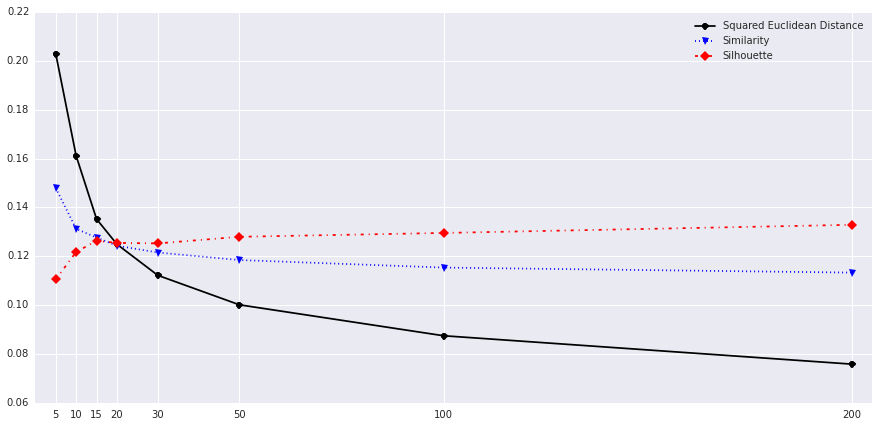

In [52]:
# now we swap training set and test set
training_set, test_set = test_set, training_set
models = buildModels(test_set)
testAndPlotTheResult(training_set, models, silhouette=True)

In [53]:
best_k = 20
best_model = models[ks.index(best_k)]
training_labels = training_data.map(lambda x: best_model.predict(x))
test_labels  = test_data.map(lambda x: best_model.predict(x))

img_training_labels = training_labels.toarray().reshape(2, 76, 87)
img_test_labels = test_labels.toarray().reshape(2, 76, 87)

In [54]:
# plot image with new colors
imgs = []
training_sim = training_data.map(lambda x: similarity(best_model.centers, x))
test_sim = test_data.map(lambda x: similarity(best_model.centers, x))

colored_brain_train = transform(newClrs, img_training_labels[0, :, :], mask=training_sim[0,:,:])
colored_brain_test = transform(newClrs, img_test_labels[0, :, :], mask=test_sim[0,:,:])
imgs.append(colored_brain_train)
imgs.append(colored_brain_test)


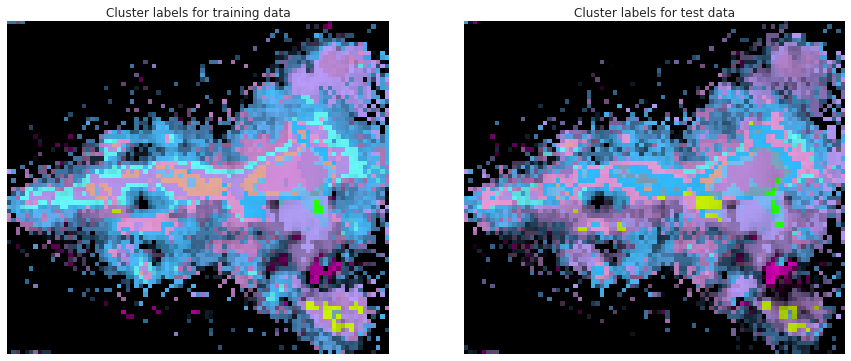

In [55]:
plot_layers_row(imgs, 2, title=["Cluster labels for training data","Cluster labels for test data"],
               interpolation='nearest')

<div class="alert alert-success">
Same as above, most of the different clusters are identified correctly with both the blue-violet (colors may change when running multiple times) in the middle.
</div>

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE:</div> Mixture models will be covered in the ASI course in greater detail.

<div class="alert alert-success">
A good alternative to K-Means clustering is <b>Mixture Models</b>.
<br><br>
Looking at the data, we could ask ourselves: <i>can we find a model that could have created this data?</i>
<br><br>
<b>Gaussian Mixture Models</b>, <b>GMM</b>, allows us to cluster data in order to maximize the probability of one point belonging to one cluster and so allowing the cluster to assume different shapes on the contrary of K-Means which forces the cluster to be circular.
<br><br>
When we assign a data point exactly to one cluster, we refer to <i>hard</i> clustering.
<br>
As opposed to this, GMM is more flexible and assigns a score to a data point for each cluster which indicates the association strength of the data point to the cluster.
</div>

In [56]:
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel

def build_mixture_models(data, ks):
    mixture_models = []
    total = 0
    data.cache()
    for k in ks:
        t0 = time.time()
        print("Gaussian mixture, number of Gaussians = %4d ..." %k, end=' ')
        mixture_models.append(GaussianMixture.train(data, k, convergenceTol=0.001,maxIterations=50, seed=10))
        t1 = time.time()
        print("[DONE] took %4.2f seconds" %(t1-t0))
        total += t1-t0
    print("Total build time: %4.2f"%total)
    return mixture_models

In [57]:
filtered_training_data.cache()
m_models = build_mixture_models(filtered_training_data, ks)

Gaussian mixture, number of Gaussians =    5 ... [DONE] took 6.76 seconds
Gaussian mixture, number of Gaussians =   10 ... [DONE] took 9.06 seconds
Gaussian mixture, number of Gaussians =   15 ... [DONE] took 12.59 seconds
Gaussian mixture, number of Gaussians =   20 ... [DONE] took 15.73 seconds
Gaussian mixture, number of Gaussians =   30 ... [DONE] took 22.51 seconds
Gaussian mixture, number of Gaussians =   50 ... [DONE] took 36.23 seconds
Gaussian mixture, number of Gaussians =  100 ... [DONE] took 70.14 seconds
Gaussian mixture, number of Gaussians =  200 ... [DONE] took 137.67 seconds
Total build time: 310.68


<div class="alert alert-success">
Above we built different models (using the same $k$ suggested for K-means) using Gaussian Mixture. To have a better understanding of the model we needed some metrics to compute the error and compare the different models.
<br><br>
Three metrics were defined:
<ol>
<li><code>model_error_mixture_1</code> computes the distance between the point and the centroid of the cluster it belongs to. We defined the centroid as the mean of the Gaussian that better approximates that series. All the distances are then summed together. </li>
<br>
<li><code>model_error_mixture_2</code> computes the cluster similarity in the same way as <i>model_error_2</i> but again considering the mean of the Gaussian that better approximates the series tas a centroid. All the similiraties are summed together and the associated error is simply the inverse of the total similarity.</li>
<br>
<li><code>model_error_mixture_3</code> tries to measure the confidence of each cluster by averaging the probability of all of its points. All the clusters probabilities are then summed together and the related error is the inverse of the sum of the means.
<br>
<div class="label label-warning">NOTE:</div> We talk about probability because with GMM clustering we have soft assignment, meaning that each point doesn't belong to one and one cluster only but it's associated to each one with a certain probability.</li>
</ol>
</div>

In [58]:
from scipy.stats import multivariate_normal

#     In Python, predict cannot currently be used within an RDD transformation or action.
#     Call predict directly on the RDD instead.

# calculate the Euclidean distance
# from each time series to its cluster center (represented by the mean of the gaussian it belongs to)
# and sum all distances
def model_error_mixture_1(data, model):
    gaussians = model.gaussians
    return model.predict(data).zip(data).map(lambda x: sqeuclidean(gaussians[x[0]].mu, x[1])).sum()


# similarity based on the mean of the gaussian 
def mm_similarity(gaussian, point):
    if np.std(point)==0:
        return 0
    return np.corrcoef(gaussian.mu, point)[0, 1]

def model_error_mixture_2(data, model):
    gaussians = model.gaussians
    sim = model.predict(data).zip(data).map(lambda x: mm_similarity(gaussians[x[0]], x[1])).sum()
    return 1/sim 

# compute the mean probability in each cluster and sum
def model_error_mixture_3(data, model):
    return 1/model.predictSoft(data).map(lambda l: (np.argmax(l),(max(l),1)))\
                .reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1])).map(lambda x: x[1][0]/x[1][1]).sum()

In [59]:
def testAndPlotTheResultMixture(data, models, silhouette=False):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_mixture_1(data, model) for model in models])
    # error of models when using 
    errors_2 = np.asarray([model_error_mixture_2(data, model) for model in models])
    # error of models when using similarity
    errors_3 = np.asarray([model_error_mixture_3(data, model) for model in models])
    # plot the errors with each value of K
    plt.figure(figsize=(15,7))
    plt.xlim([0,205])
    plt.xticks(ks)
    plt.plot(ks, errors_1 / errors_1.sum(), 'k-o', label='Squared Euclidean Distance')
    plt.plot(ks, errors_2 / errors_2.sum(), 'b:v', label='Similarity')
    plt.plot(ks, errors_3 / errors_3.sum(), 'g--p', label='Mean probability (per cluster)' )
    if silhouette:
        train_array = np.array(data.collect())
        silhouettes = []
        for model in models:
            train_labels = np.array(model.predict(data).collect())
            silhouettes.append(1/(silhouette_score(train_array, train_labels)+1))
            
        plt.plot(ks, silhouettes/sum(silhouettes),'-.D', label='Silhouette', color='r')

    plt.legend()
    plt.show()

/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


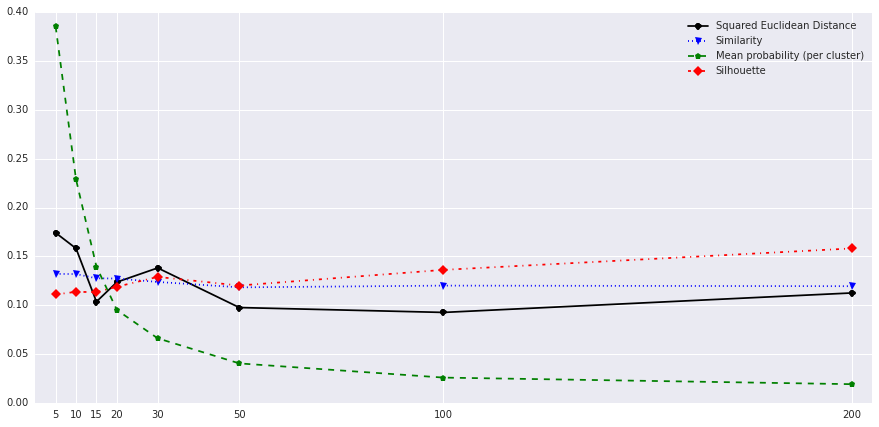

In [60]:
testAndPlotTheResultMixture(filtered_training_data, m_models, silhouette=True)

<div class="alert alert-success">
As expected, the best number of clusters remain in the same small interval as before. $k=15$ and $k=20$ seem like the best number of clusters according to the plot above.
</div>

In [61]:
best_m_k = 20
best_m_model = m_models[ks.index(best_m_k)]
gaussians = best_m_model.gaussians

# data transformed to go into the model
prepared_data = data.tordd().map(lambda x: np.array(x[1]))
# predicting labels for data
m_labels = best_m_model.predict(prepared_data).collect()
# reshaping to draw the image
m_img_labels =  np.reshape(m_labels, (2, 76, 87))

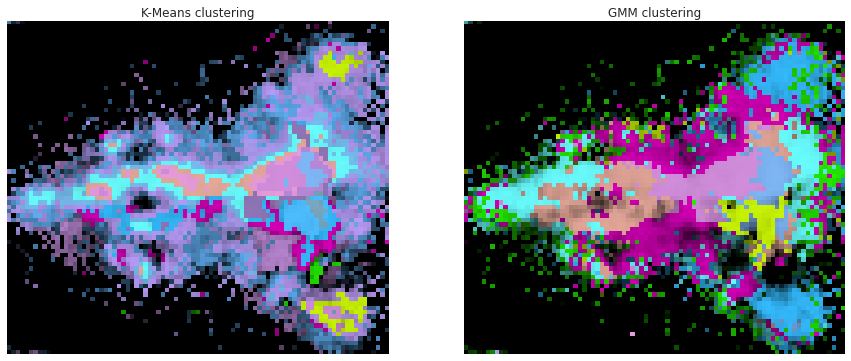

In [62]:
# computing similarity
m_sim = best_m_model.predict(prepared_data).zip(prepared_data)\
        .map(lambda x: mm_similarity(gaussians[x[0]], x[1])).collect()
       
# reshaping to build a mask    
m_sim = np.reshape(m_sim,(2, 76, 87))
# transforming the image
m_brainmap = transform(newClrs, m_img_labels[0,:,:], mask=m_sim[0,:,:])
plot_layers_row([brainmap, m_brainmap], 2, title=["K-Means clustering", "GMM clustering"], 
                aspect='equal', interpolation='nearest')

<div class="alert alert-success">
Above are the predictions for the two different clustering techniques: KMeans and GMM.
<br><br>
We can see from the colors that the GMM mantains a more symmetric shape and is able to divide the brain in different countable regions instead of classifying the different pixels without creating distinct visible regions.
</div>

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# 5. Extra: Time Series Classification
<br>
<div class="alert alert-success">One of the major problems of the approach followed above is that the implementation of the K-Means that we've used defines the proximity of points using Euclidean Distance and doesn't take into account the time series during a prediction.
<br><br>
First of all we should use a better measure of similarity.
<br><br>
<b>Dynamic Time Warping</b> finds the optimal non-linear alignment between two time series. The Euclidean distances between alignments are then much less susceptible to pessimistic similarity measurements due to distortion in the time axis.
<br><br>
<b>How does this work?</b>
<br><br>Considering two time series $Q$ and $C$ of same length $n$, we have to create a matrix $n \times n$ and find a path through this matrix that minimizes the cumulative distance. The optimal path is found via dynamic programming, specifically through the following recursive function: <br><br>
\begin{equation}
\gamma(i,j)=d(q_i,c_j)+min ( \gamma(i-1,j-1),\gamma(i-1,j),\gamma(i,j-1))
\end{equation}
<br><br>
Since DTW is $\mathcal{O}(n^2)$ where $n$ is the length of the time series, it is better to use <b>LB Keogh</b> lower bound of dynamic time warping.
<br>
This is defined as:
\begin{equation}
LBKeogh(Q,C)=\sum\limits^{n}_{i=1}(c_i-U_i)^2I(c_i>U_i)+(c_i-L_i)^2I(c_i<L_i)
\end{equation}
where $U_i$ and $L_i$ are upper and lower bound for time series $Q$.
<br><br>
For major details on these implementation, please follow <a href="https://github.com/alexminnaar/time-series-classification-and-clustering">this</a> link.
</div>

In [63]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [64]:
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind, i in enumerate(s1):
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)

In [65]:
class KMeansDTW(object):
    def __init__(self):
        self.window = 5
        
    def train(self, data, num_cluster, iterations=30, w=None):
        w = w or self.window
        rand = np.random.randint(0, len(data), size=num_cluster)
        centroids = [data[i] for i in rand]
        counter=0
        print("Iterations: ", end="")
        for n in range(iterations):
            counter+=1
            print(counter, end=" ")
            assignments={}
            #assign data points to clusters
            for ind,i in enumerate(data):
                min_dist=float('inf')
                closest_clust=None
                for c_ind,j in enumerate(centroids):
                    if LB_Keogh(i, j, w) < min_dist:
                        cur_dist = DTWDistance(i,j,w)
                        if cur_dist < min_dist:
                            min_dist = cur_dist
                            closest_clust = c_ind
                if closest_clust in assignments:
                    assignments[closest_clust].append(ind)
                else:
                    assignments[closest_clust]=[]

            #recalculate centroids of clusters
            for key in assignments:
                clust_sum = 0
                for k in assignments[key]:
                    clust_sum = clust_sum+data[k]
                centroids[key] = [m/len(assignments[key]) for m in clust_sum]

        self.centroids  = np.array(centroids)
        return self
    
    
    def predict(self, data):
        predictions = []
        for x in data:
            min_dist = float('inf')
            closest_clust = None
            for c_ind,j in enumerate(self.centroids):
                if LB_Keogh(x, j, self.window) < min_dist:
                    cur_dist = DTWDistance(x, j, self.window)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_ind
            predictions.append(closest_clust)
        return np.array(predictions)

In [66]:
training_data = data.tordd().map(lambda x: np.array(x[1])).collect()

In [67]:
dtw_model = KMeansDTW().train(training_data, 6)
dtw_imgs = []

Iterations: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

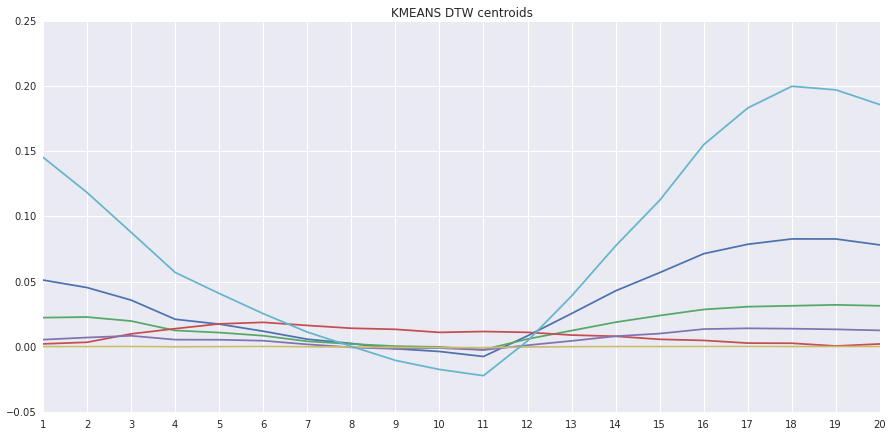

In [68]:
plot_voxels(dtw_model.centroids.T, title="KMEANS DTW centroids")
predictions = np.reshape(dtw_model.predict(training_data),(2, 76, 87))
dtw_sim = np.array([similarity(dtw_model.centroids, v) for v in training_data]).reshape((2, 76, 87))
dtw_imgs.append(transform(newClrs, predictions[0, :, :], mask=dtw_sim[0, :, :]))

<div class="alert alert-success">
The plot above shows the centroids of the KMeans algorithm with Dynamic Time Warping. As we can see, with 6 different clusters we were able to obtain 6 different centroids that we expect clusterize the data in a good way.
<br><br>
Below, we are doing the same thing with filtered data on the same threshold as above.
</div>

In [69]:
#trying with filtered data
filtered_training_data = data.filter(lambda x: x.std() > threshold).tordd().map(lambda x: np.array(x[1])).collect()
dtw_model_2 = KMeansDTW().train(filtered_training_data, 6)

Iterations: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

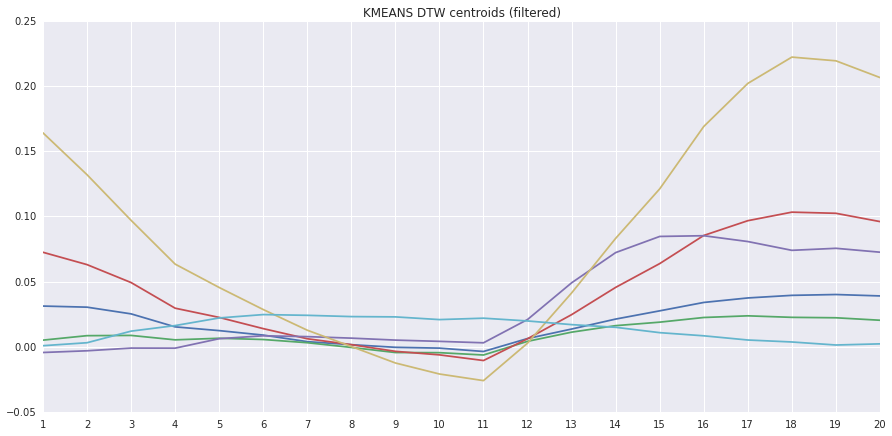

In [70]:
plot_voxels(dtw_model_2.centroids.T, title="KMEANS DTW centroids (filtered)")
predictions = np.reshape(dtw_model.predict(training_data), (2, 76, 87))
dtw_sim_2 = np.array([similarity(dtw_model_2.centroids, v) for v in training_data]).reshape((2, 76, 87))
dtw_imgs.append(transform(newClrs, predictions[0, :, :], mask=dtw_sim_2[0, :, :]))

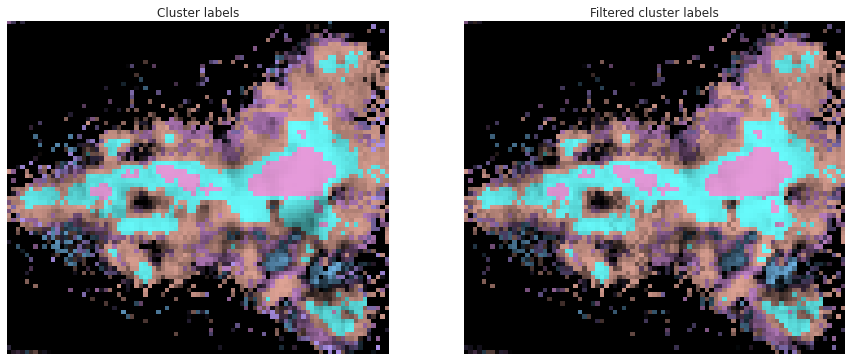

In [72]:
plot_layers_row(dtw_imgs, 2, title=["Cluster labels", "Filtered cluster labels"], interpolation='nearest')

<div class="alert alert-success">
Above, we can see the two images colored with the prediction with the unfiltered DTW KMeans and the filtered DTW KMeans, left and right respectively.
<br><br>
As we can see, the two images are nearly the same (they are not identical, we checked every pixel to be sure about our comment).
<br><br>
In our opinion, this is a clear meaning that taking into account time series for clustering, allows for a better division of data without the need of using a threshold to remove the black pixels for a better clustering.
</div>

# 6 Further improvements
<br>
<div class="alert alert-success">
As usual, we list here some comments, further algorithms and better techniques that could have been approached to improve the notebook.
<br>
<ul>
<li>First of all, we really think that 20 images (time periods) are not enough and the data set was too small to work properly. We found the complete dataset on github at this <a href="https://github.com/sryza/aas/tree/master/ch11-neuro/fish-long">link</a> with 240 images.
<br>
Unfortunately, we didn't have the time to use this more complete dataset but we expect different and better results.
<br><br>
<li>Second, we thought on looking at the shape of the various signals instead that looking at their value and cluster them according to that. We didn't analayze further this possible algorithm and it remains just a suggestion.
<br><br>
<li>Another worth-trying algorithm could be dbscan, that clusters data according to density rather than distance, although we don't expect very good results given the topic of the data.
</ul>
</div>

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).